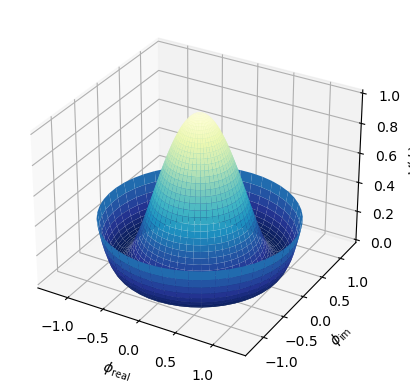

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
r = np.linspace(0, 1.25, 50)
p = np.linspace(0, 2*np.pi, 50)
R, P = np.meshgrid(r, p)
Z = ((R**2 - 1)**2)

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)

# Tweak the limits and add latex math labels.
ax.set_zlim(0, 1)
ax.set_xlabel(r'$\phi_\mathrm{real}$')
ax.set_ylabel(r'$\phi_\mathrm{im}$')
ax.set_zlabel(r'$V(\phi)$')

plt.show()


# Step 1: Define constants

This section defines constants to be used in the notebook

In [2]:
# Verbosity constants
ERROR = 1
WARNING = 2

VERBOSITY_DICT = {1: "ERROR",
                  2: "WARNING"}

# Step 2: Compile functions

This section has all the necessary functions to create the surfaces based on the Zernike modes

In [9]:
def compute_zernike_polynomial(m_index,
                               n_index,
                               rho,
                               varphi,
                               verbose=False):
    """
    This function computes the value of a Zernike polynomial on polar coordinates given the Zernike coefficients
    
    Input:
        m_index (int): The m number of the Zernike Polynomial
        n_index (int): The n number of the Zernike Polynomial
        rho (float): The distance of the point to the center (radius in polar coordinates) 
        varphi(float): The angle of the point with respect to x-axis (angle in polar coordinates)
        
    Returns:
    """
    
    # First check if the zernike parameters are valid
    if not checkZernikeParameters(m_index, 
                                  n_index, 
                                  rho, 
                                  verbose):
        return False, None
    
    # Obtain the absolute value of the m index
    m_abs_index = abs(m_index)
    
    # Obtain the sign of the m index
    m_sign = m_index // m_abs_index
    
    # Compute the radial polynomial value at rho
    r_value = compute_radial_value(m_abs_index, 
                                   n_index, 
                                   rho,
                                   verbose)
    
    # Compute the zernike value
    if m_sign == 1:
        zernike_value = r_value * math.cos(m_abs_index * phi)
    else:
        zernike_value = r_value * math.sin(m_abs_index * phi)
        
    return zernike_value


def compute_radial_value(m_index, n_index, rho, verbose=False):
    """
    Computes the radial polynomial at ro given m and n indexes of the Zernike Polynomials
    
    Input:
        m_index (int): The m number of the Zernike Polynomial
        n_index (int): The n number of the Zernike Polynomial
        rho (float): The distance of the point to the center (radius in polar coordinates)
        
    Returns:
        r_value(float): The value of the radial polynomial at ro
    """
    
    # Default value of the polynomial
    if rho == 1:
        return 1
    
    # Value if n-m is odd
    r_value = 0
    
    
    n_minus_m = n_index - m_index
    module = n_minus_m % 2
    
    # If the module of n-m is even calculate
    if module == 0:
        # Compute the index of the sumatory and add 1 for the loop
        sumatory_index = (n_minus_m)//2 + 1
        
        # The summatory
        for k in range(0, sumatory_index):
            
            # Compute the numerator: (-1)^k * (n-k)!
            numerator = (-1)**k * math.factorial(n-k)
            
            # Compute the numbers from which we will compute their factorials for the denominator
            n_plus_m_d2_minus_k = (n_index + m_index)//2 - k  # (n+m)/2 - k
            n_minus_m_d2_minus_k = (n_index - m_index)//2 - k # (n-m)/2 - k
            
            # Compute denominator: k! * ((n+m)/2 - k)! *((n-m)/2 - k)!
            denominator = math.factorial(k) * math.factorial(n_plus_m_d2_minus_k) * math.factorial(n_minus_m_d2_minus_k)
            
            # Update the total sum
            r_value += numerator/denominator * rho**(n-2*k)
        
    return r_value
            
        
def check_zernike_parameters(m_index, n_index, rho, verbose=False):
    """
    This function checks that the zernike parameters are valid
    
    Input:
        m_index (int): The m number of the Zernike Polynomial
        n_index (int): The n number of the Zernike Polynomial
        rho (float): The distance of the point to the center (radius in polar coordinates) 
        verbose (bool): Indicates if the errors are displayed in console. Default is False.
    
    Returns:
        bool: True if the parameters are correct, False otherwise
    """
    
    # If n is lower than m there is an error
    if n_index < abs(m_index):
        if verbose:
            msg = f"The n index is smaller than m index: {n_index} < {abs(m_index)}"
            print_verbose_msg(msg, ERROR)
        return False
    
    # If the radius is less than 0 or greater than 1 there is an error
    if rho < 0 or rho > 1:
        if verbose:
            msg = f"The radius (ro) must be between -1 and 1. Radius is {rho}"
            print_verbose_msg(msg, ERROR)
        return False
    
    return True
            

def polar_samples_1d_circle(n_circles=10, n_samples=50):
    """
    This function samples radiuses and angles from the unit disk
    Input:
        n_circles (int): Optional. The number of concentric circles where the points will be sampled from
        n_samples (int): Optional. The number of samples of the outer circle of radius one. For the rest the number
                        of samples is proportional to the radius.
                        
    Returns:
        radius_samples (np.array): The array containing the radius polar coordinates of the points
        thetas_samples (np.array): The array containing the angle polar coordinates of the points
    """
    
    # radius_samples = np.empty([0])
    # thetas_samples = np.empty([0])
    
    # for i in range(1, n_circles+1):
        # n_subsamples = round((1 - (n_circles - i)/n_circles) * n_samples)
      
        # i_radiuses = np.full((n_subsamples,), i/n_circles)
        # i_thetas = np.arange(0, 2* np.pi, 2* np.pi/n_subsamples)
        
        # radius_samples = np.concatenate((radius_samples, i_radiuses))
        # thetas_samples = np.concatenate((thetas_samples, i_thetas))
    
    radius_samples = np.arange(0, 1, 1/n_circles)
    thetas_samples = np.arange(0, 2* np.pi, 2* np.pi/n_samples)
    return radius_samples, thetas_samples


def plot_2d_polar_points(radiuses, thetas):
    fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
    ax.set_rticks([])
    ax.plot(thetas, radiuses, 'k.')


def print_verbose_msg(msg, level):
    """
    This function prints a message and its level of severity
    
    Input:
        msg (string): The message to display
        level (int): The dictionary key that contains the level of severity
    
    Returns:
        None
    """
    complete_msg = f"{VERBOSITY_DICT[level]}: {msg}"
    print(complete_msg)

In [12]:
radiuses, thetas = polar_samples_1d_circle(n_samples=100)
print(radiuses.shape)
print(radiuses)
print(R)
print(thetas.shape)
print(thetas)
print(P)
print(z.shape)
print(R.shape)
print(P.shape)
print(z)

(10,)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[[0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]]
(100,)
[0.         0.06283185 0.12566371 0.18849556 0.25132741 0.31415927
 0.37699112 0.43982297 0.50265482 0.56548668 0.62831853 0.69115038
 0.75398224 0.81681409 0.87964594 0.9424778  1.00530965 1.0681415
 1.13097336 1.19380521 1.25663706 1.31946891 1.38230077 1.44513262
 1.50796447 1.57079633 1.63362818 1.69646003 1.75929189 1.82212374
 1.88495559 1.94778745 2.0106193  2.07345115 2.136283   2.19911486
 2.26194671 2.32477856 2.38761042 2.45044227 2.51327412 2.57610598
 2.63893783 2.70

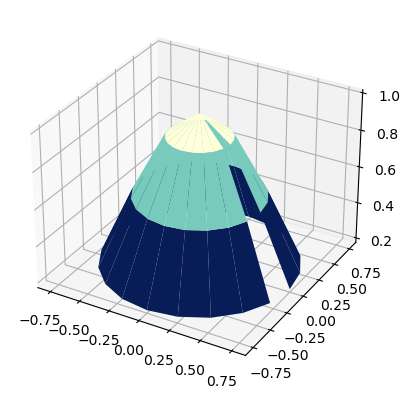

In [13]:
radiuses, thetas = polar_samples_1d_circle(n_circles=4, n_samples=20)
R, P = np.meshgrid(radiuses, thetas)
z = ((R**2 - 1)**2)
X, Y = R*np.cos(P), R*np.sin(P)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the surface.
ax.plot_surface(X, Y, z, cmap=plt.cm.YlGnBu_r)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

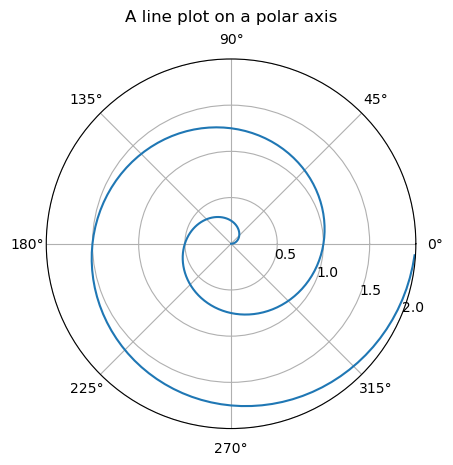

In [21]:
r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r
print(r)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, r)
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()
